In [48]:
#### ALL NOTEBOOK SHOULD HAVE SOME VERSION OF THIS #####################################
########################################################################################
%load_ext autoreload
%autoreload 2
import os
import sys

currentdir = os.getcwd()
# go to root directory. change the # of os.path.dirnames based on where currentdir is
parentdir = os.path.dirname(os.path.dirname(currentdir)) 
# chek where I'm at. if I go too far up the tree, go back
if 'Protein-Purification-Model-Public' not in parentdir: parentdir = currentdir
if parentdir not in sys.path: sys.path.insert(0,parentdir)
########################################################################################

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import utils
import visualization.simple_data_vis as vis
import surrogate_models.nn_defs as engine
import kerastuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
# load data from just-private/data
filename1 = 'mol_res_scan_results_10_sourceS.csv'
data1 = utils.load_data(parentdir, filename1)

filename2 = 'mol_res_scan_results_10_sourceQ.csv'
data2 = utils.load_data(parentdir, filename2)

# since currently data is just one big dataframe, select model inputs as X and purity, yield as Y
# should be the same for both datasets
x = [*data1.columns[:2],*data1.columns[4:]]
y = data1.columns[2:4]

In [58]:
trains, tests = utils.data_pipeline([data1,data2], x, y, cv = 1)

In [6]:
# define models to test out. a loop makes sense too 
def generate_models(filenames):
    models = []
    for filename in filenames:
        dlr = engine.create_deterministic_linear_regressor(
            FEATURE_NAMES = x,
            TARGET_NAMES = y,
            name = 'DLR_'+filename
        )

        plr = engine.create_probabilistic_linear_regressor(
            FEATURE_NAMES = x,
            TARGET_NAMES = y,
            name = 'PLR_'+filename,
        )

        dnn = engine.create_deterministic_nn(
            FEATURE_NAMES = x,
            TARGET_NAMES = y,
            hidden_units = [16,8,4],
            name = 'DNN_'+filename
        )

        pnn = engine.create_probabilistic_nn(
            FEATURE_NAMES = x,
            TARGET_NAMES = y,
            hidden_units = [16,8,4,],
            name = 'PNN_'+filename,
        )

        models.append([dlr,plr,dnn,pnn])
    return models

all_models = generate_models([filename1,filename2])

In [65]:
# train all the models under the same conditions
learning_rate = 0.01
epochs = 100
optimizer = 'Adam' # change manually or come up with dictionary?
losses = ['mean_squared_error', engine.negative_loglikelihood]*2
loss_weights = (1/trains[0][0][1].mean().div(trains[0][0][1].mean().max())).round(2).to_dict() 
histories = {}

for models, train, test, filename in zip(all_models, trains, tests, [filename1,filename2]):
    for m,l in zip(models,losses):
        histories[utils.get_model_name(m,filename)] = engine.run_experiment(
            model = m, 
            loss = {y[0]:l,y[1]:l},
            loss_weights = loss_weights,
            optimizer = tf.keras.optimizers.Adam,
            learning_rate = learning_rate,
            num_epochs = epochs,
            train_dataset = train[0], 
            test_dataset = test[0],
            verbose = 0,
            log = 0
            )

settings = {'learning_rate' : learning_rate,
            'epochs' : epochs,
            'optimizer': optimizer,
            'loss_weights': loss_weights,
            'dataset' : filename1+'\n'+filename2}

Start training the model DLR_mol_res_scan_results_10_sourceS.csv ...


KeyboardInterrupt: 

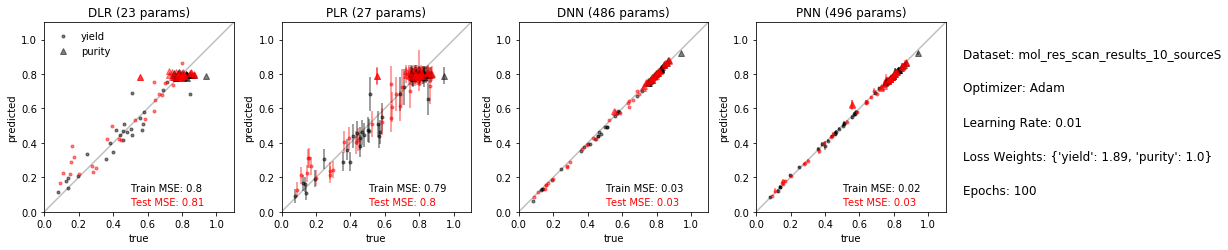

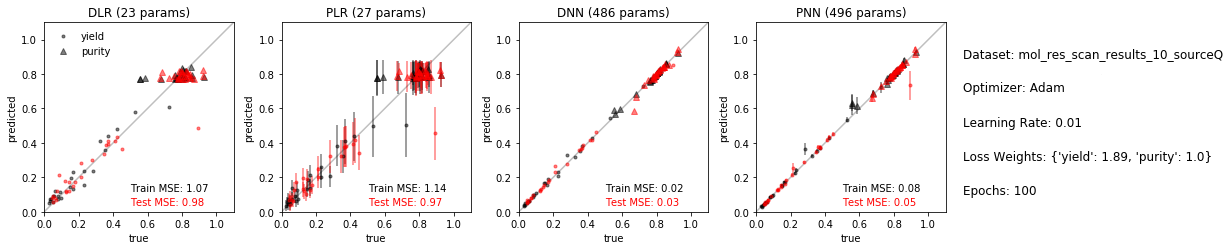

In [14]:
# check model predictions
settings['dataset'] = filename1
vis.scatter_hats(all_models[0], trains[0], tests[0], settings, N = 25)
settings['dataset'] = filename2
vis.scatter_hats(all_models[1], trains[1], tests[1], settings, N = 25)

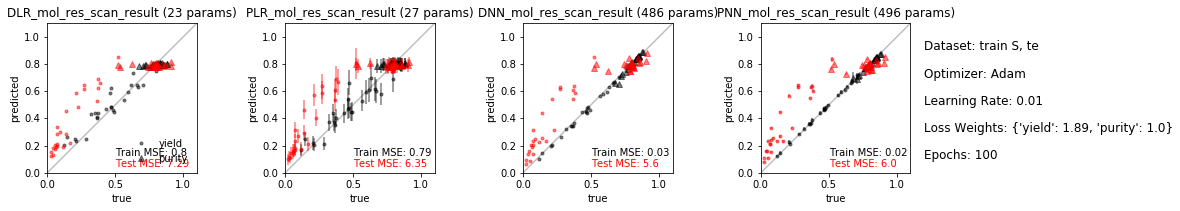

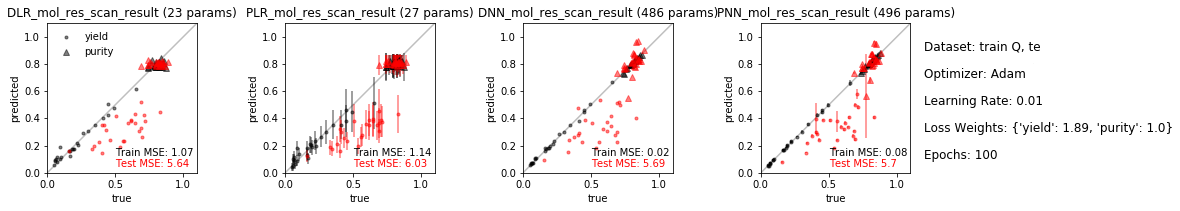

In [20]:
settings['dataset'] = "train S, test Q"
vis.scatter_hats(all_models[0], trains[0], tests[1], settings, N = 25)
settings['dataset'] = "train Q, test S"
vis.scatter_hats(all_models[1], trains[1], tests[0], settings, N = 25)

In [27]:
# put all data together for resin-agnostic model
data2.index = data2.index + len(data1)
all_data = data1.append(data2)

In [35]:
all_train, all_test = data_pipeline([all_data,],x,y)

In [55]:
ra_models = generate_models(['S+Q',])[0]

In [56]:
# this is why we make functions...

learning_rate = 0.005
epochs = 100
optimizer = 'Adam' # change manually or come up with dictionary?
losses = ['mean_squared_error', engine.negative_loglikelihood]*2
loss_weights = (1/all_train[1].mean().div(all_train[1].mean().max())).round(2).to_dict() 
histories = {}

for m,l in zip(ra_models,losses):
    histories[utils.get_model_name(m,'S+Q')] = engine.run_experiment(
        model = m, 
        loss = {y[0]:l,y[1]:l},
        loss_weights = loss_weights,
        optimizer = tf.keras.optimizers.Adam,
        learning_rate = learning_rate,
        num_epochs = epochs,
        train_dataset = all_train, 
        test_dataset = all_test,
        verbose = 0,
        log = 0
        )

settings = {'learning_rate' : learning_rate,
            'epochs' : epochs,
            'optimizer': optimizer,
            'loss_weights': loss_weights,
            'dataset' : 'S+Q'}

Start training the model DLR_ ...
Evaluating model performance...
Train MSE: 2.228
Test MSE: 2.28
Start training the model PLR_ ...
Evaluating model performance...
Train MSE: 2.433
Test MSE: 2.462
Start training the model DNN_ ...
Evaluating model performance...
Train MSE: 1.161
Test MSE: 2.227
Start training the model PNN_ ...
Evaluating model performance...
Train MSE: 1.557
Test MSE: 1.754


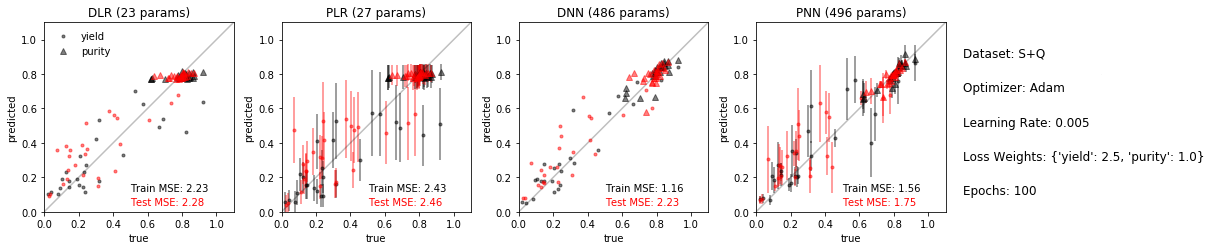

In [57]:
vis.scatter_hats(ra_models, all_train, all_test, settings, N = 25)